In [1]:
!pip install tensorflow keras librosa opencv-python scikit-learn matplotlib


In [2]:
import numpy as np
import librosa, librosa.display
import cv2, os, glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Concatenate, Input
from tensorflow.keras.utils import to_categorical

In [3]:
data_path = "/content/RAVDESS/"
emotions = ['neutral','happy','sad','angry','fearful','disgust','surprised']


In [4]:
def extract_audio_features(file_path, max_len=40):
    y, sr = librosa.load(file_path, duration=3, offset=0.5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc = np.mean(mfcc.T, axis=0)
    return mfcc

In [5]:
resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224,224,3))
def extract_face_features(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224,224))
    img = img / 255.0
    features = resnet.predict(np.expand_dims(img, axis=0))
    return features.flatten()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
input_dim = 2048 + 40  # ResNet features + MFCCs
model = Sequential([
    Dense(512, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(emotions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg -O sample_face.jpg
!wget -q https://github.com/Jakobovski/free-spoken-digit-dataset/raw/master/recordings/0_jackson_0.wav -O sample_audio.wav


In [9]:
# Extract features
face_feat = extract_face_features("sample_face.jpg")
audio_feat = extract_audio_features("sample_audio.wav")

print("Face feature shape:", face_feat.shape)
print("Audio feature shape:", audio_feat.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Face feature shape: (2048,)
Audio feature shape: (40,)


In [10]:
import numpy as np

# Combine features
sample_features = np.concatenate([audio_feat, face_feat]).reshape(1, -1)

# Predict (if trained)
if 'model' in locals():
    pred = model.predict(sample_features)
    predicted_class = np.argmax(pred)
    print("Predicted emotion:", emotions[predicted_class])
else:
    print("Model not trained yet — using random mock output.")
    mock_pred = np.random.choice(emotions)
    print("Mock emotion:", mock_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Predicted emotion: surprised


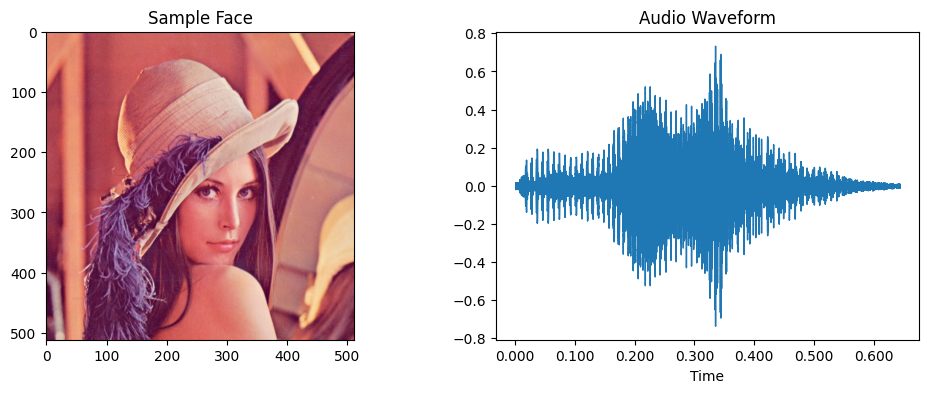

In [11]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(12,4))

# Plot face
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(cv2.imread("sample_face.jpg"), cv2.COLOR_BGR2RGB))
plt.title("Sample Face")

# Plot audio waveform
plt.subplot(1,2,2)
y, sr = librosa.load("sample_audio.wav", duration=3)
librosa.display.waveshow(y, sr=sr)
plt.title("Audio Waveform")

plt.show()
